# What are the chances for a PA to get approved?

In this notebook, I explore the PA data for the rejected claims and build a simple logistic regression model to predict the probability of a PA getting approved given the claim and patient information.

In [1]:
# to make tab autocomplete work
%config Completer.use_jedi = False

In [2]:
# imoprt packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [3]:
# read data
dim_pa_claims_rejected = pd.read_csv('../CoverMyMeds_data/dim_pa_claim_rejected.csv')

# Explore the data

In [4]:
dim_pa_claims_rejected.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,reject_reason,dim_pa_id,dim_date_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved,Type
0,1,417380,A,75.0,0,In_formulary_needs_PA,1.0,1,1,1,0,1,T2
1,3,417740,A,76.0,0,Limit_exceeded,2.0,1,1,0,0,1,T1
2,10,417380,A,75.0,0,In_formulary_needs_PA,3.0,1,0,0,1,1,T7
3,11,999001,A,76.0,0,Limit_exceeded,4.0,1,1,1,0,1,T2
4,15,417614,A,70.0,0,Not_in_formulary,5.0,1,0,1,0,1,T5


In [5]:
# Number of observations per payer
dim_pa_claims_rejected.groupby('bin')['dim_claim_id'].nunique()

bin
417380    133579
417614    242268
417740    116031
999001     64073
Name: dim_claim_id, dtype: int64

In [6]:
# Number of PA rejected cases
len(dim_pa_claims_rejected[dim_pa_claims_rejected['pa_approved']==0])

147632

In [7]:
# Number of PA approved cases
len(dim_pa_claims_rejected[dim_pa_claims_rejected['pa_approved']==1])

408319

#### There is class imbalance between the PA approved and PA rejected cases.

In [8]:
# correlation of features and pa_approved
dim_pa_claims_rejected[['bin','reject_code','correct_diagnosis','tried_and_failed','contraindication','pa_approved']].corr()['pa_approved']

bin                  0.140196
reject_code          0.475336
correct_diagnosis    0.035889
tried_and_failed     0.125490
contraindication    -0.223283
pa_approved          1.000000
Name: pa_approved, dtype: float64

In [9]:
# Seperate dim_pa_claims_rejected into X and y

X = dim_pa_claims_rejected[['bin','drug', 'reject_reason','correct_diagnosis','tried_and_failed','contraindication']]
y = dim_pa_claims_rejected['pa_approved']

In [10]:
# Add new column payer
# convert bin from int to str

X_copy = X.copy()
X_copy['payer'] = ''

X_copy.loc[X_copy.bin==417380, 'payer'] = 'C1'
X_copy.loc[X_copy.bin==999001, 'payer'] = 'C2'
X_copy.loc[X_copy.bin==417740, 'payer'] = 'C3'
X_copy.loc[X_copy.bin==417614, 'payer'] = 'C4'

In [11]:
X_copy.head()

,bin,drug,reject_reason,correct_diagnosis,tried_and_failed,contraindication,payer
0,417380,A,In_formulary_needs_PA,1,1,0,C1
1,417740,A,Limit_exceeded,1,0,0,C3
2,417380,A,In_formulary_needs_PA,0,0,1,C1
3,999001,A,Limit_exceeded,1,1,0,C2
4,417614,A,Not_in_formulary,0,1,0,C4


In [12]:
# interaction terms

X_copy['drug_payer'] = X_copy['drug'].astype(str) + X_copy['payer'].astype(str)
X_copy['diagnosis'] = X_copy['correct_diagnosis'].astype(str) + X_copy['tried_and_failed'].astype(str) + X_copy['contraindication'].astype(str)

In [13]:
X_copy.head()

,bin,drug,reject_reason,correct_diagnosis,tried_and_failed,contraindication,payer,drug_payer,diagnosis
0,417380,A,In_formulary_needs_PA,1,1,0,C1,AC1,110
1,417740,A,Limit_exceeded,1,0,0,C3,AC3,100
2,417380,A,In_formulary_needs_PA,0,0,1,C1,AC1,001
3,999001,A,Limit_exceeded,1,1,0,C2,AC2,110
4,417614,A,Not_in_formulary,0,1,0,C4,AC4,010


In [14]:
# One Hot Encoding for categorical variables

X_final = X_copy[['diagnosis','drug_payer']]
X_enc=pd.get_dummies(X_final, drop_first=True)

In [15]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state =42, shuffle = True, test_size = 0.25, stratify = y)

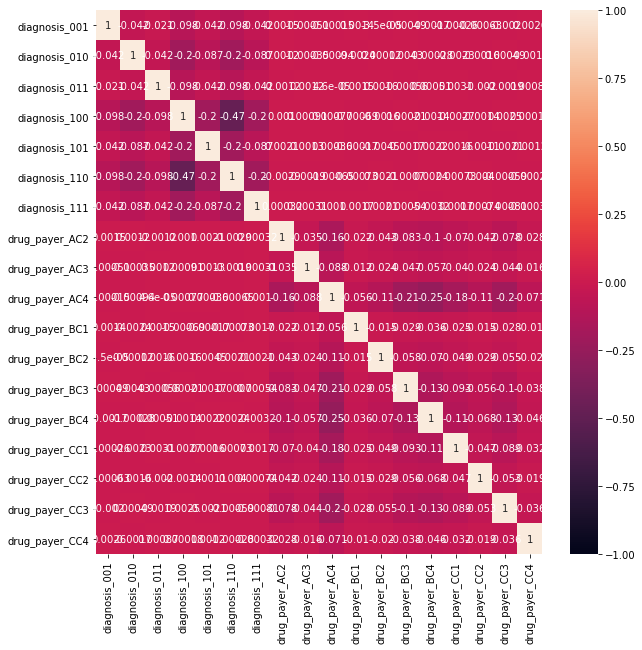

In [16]:
# correlation between features

plt.figure(figsize=(10,10))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)

#### Given the small correlation values, the features can be safely assumed to be linearly independent.

# Logistic Regression

In [17]:
# calculate class weights to balance classes
# Wj = n_samples / (n_classes * n_samples_j)

W_0 = len(y)/(2*len(y[y==0]))
W_1 = len(y)/(2*len(y[y==1]))

print(W_0)
print (W_1)

1.8828946298905387
0.6807802233057977


In [18]:
# Logistic regression classifier
clf = LogisticRegression(random_state =42, solver = 'lbfgs', max_iter = 1000,class_weight={0:W_0,1:W_1})

In [19]:
# cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# evaluate model
# scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
scores = cross_validate(clf, X_train, y_train, scoring = ['roc_auc','f1'], cv = cv, n_jobs = -1)

# report performance
# ROC_AUC
print('ROC_AUC: %.3f (%.3f)' % (np.mean(scores['test_roc_auc']), np.std(scores['test_roc_auc'])))

# F1 score
print('F1-score: %.3f (%.3f)' % (np.mean(scores['test_f1']), np.std(scores['test_f1'])))

ROC_AUC: 0.878 (0.001)
F1-score: 0.834 (0.002)


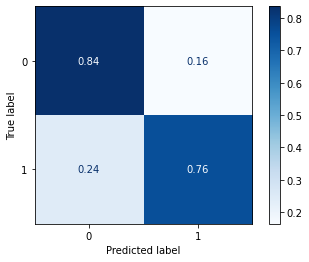

In [20]:
# confusion matrix
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_train, y_train,cmap=plt.cm.Blues, normalize='true')
plt.savefig('../Plots/PA_ConfusionMatrix.png')
plt.show()  

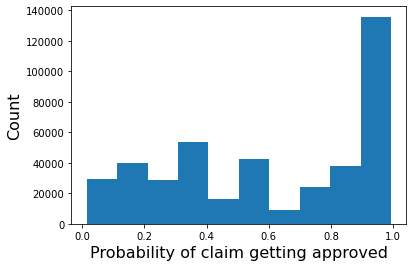

In [21]:
# predict probability distribution of predictions

y_pred=clf.predict_proba(X_train)[:,1]
plt.hist(y_pred)
plt.xlabel('Probability of claim getting approved', fontsize=16)
plt.ylabel('Count', fontsize=16)
# plt.savefig('../Plots/PA_probabilityDistribution.png')
plt.show()

<AxesSubplot:>

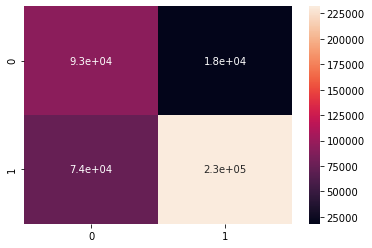

In [22]:
thresh = 0.5
y_test_pred = np.where(y_pred>thresh, 1, 0)
cm = confusion_matrix(y_train,y_test_pred)
sns.heatmap(cm, annot=True)

In [23]:
# A simple function to predict the probability of PA approval given claim and patient information

def WillPAGetApproved (correct_diagnosis, tried_and_failed, contraindication, drug, 
                         payer):
    
    diagnosis = str(correct_diagnosis)+str(tried_and_failed)+str(contraindication)
    drug_payer = str(drug)+str(payer)

    X = np.array(['001','010','011','100','101','110','111','AC2', 'AC3','AC4','BC1','BC2','BC3','BC4','CC1',
                 'CC2', 'CC3','CC4'])
    
    X1 = np.where((X==diagnosis)|(X==drug_payer), 1, 0)
    proba = clf.predict_proba(X1.reshape(1,-1))[0][1]
    
    proba_1 = round(proba,2)*100
    print (f"The probability of PA approval is {proba_1}%")
    
    return None


In [24]:
# check predictions

correct_diagnosis = 1
tried_and_failed = 1
contraindication = 0
drug = 'B'            # One of A, B and C
payer = 'C4'           # One of C1, C2, C3 and C4

WillPAGetApproved(correct_diagnosis, tried_and_failed, contraindication, drug, payer)

The probability of PA approval is 98.0%


In [34]:
# coefficients
regression_coeff = clf.coef_

In [36]:
# Odds ratios
# baseline for diagnosis : diagnosis_000
# baseline for drug_payer : drug_payer_AC1

OR = np.exp(regression_coeff)
print(OR)

[[1.26973211e-01 2.48154246e+00 3.67915833e-01 1.37386722e+00
  1.85803838e-01 3.37799056e+00 5.21935522e-01 2.43991484e-01
  7.93627647e-02 8.44850744e-03 8.54644314e-02 1.24304575e-01
  3.43034646e-03 3.53810162e-01 2.56141918e-03 2.29590936e-02
  3.91529720e-02 1.18688377e-02]]


# Statsmodels
#### To check the significance of the model

In [25]:
import statsmodels.api as sm

In [26]:
model = sm.Logit(endog=y_train, exog=sm.add_constant(X_train)).fit()

Optimization terminated successfully.
         Current function value: 0.371655
         Iterations 9


In [27]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:            pa_approved   No. Observations:               416963
Model:                          Logit   Df Residuals:                   416944
Method:                           MLE   Df Model:                           18
Date:                Thu, 27 May 2021   Pseudo R-squ.:                  0.3579
Time:                        09:09:47   Log-Likelihood:            -1.5497e+05
converged:                       True   LL-Null:                   -2.4133e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.7695      0.043    111.774      0.000       4.686       4.853
diagnosis_001     -1.9938      0.036    -55.501      0.000      -2.064      -1.923
diagnosis_010      0.9067      0.022

# Save model

In [31]:
from joblib import dump, load
dump(clf, '../Models/PAModel_logistic.joblib')

['../Models/PAModel_logistic.joblib']